In [1]:
import os
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import jax
import cv2
import tensorflow_datasets as tfds
import tqdm
import mediapy
import numpy as np

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")

import jax.numpy as jnp
from absl import app, flags
import optax
import json
import numpy as np
from functools import partial
import orbax.checkpoint as ocp
from tensorflow_text import SentencepieceTokenizer
# from palivla.dataset import prepare_image
from palivla.tokenizer import Tokenizer
from palivla.load_model import load_model_params_decode
from scalax.sharding import MeshShardingHelper, FSDPShardingRule, PartitionSpec
from flax.training.train_state import TrainState
from jax.experimental import multihost_utils
from ml_collections import config_flags
from palivla.train_state import PaliVLATrainState
from palivla.types import TrainingBatch, RolloutBatch

# export TPU_VISIBLE_DEVICES=0 
# export TPU_CHIPS_PER_HOST_BOUNDS=1,1,1 
# export TPU_HOST_BOUNDS=1,1,1 
# export TPU_MESH_CONTROLLER_ADDRESS=localhost:8476 
# export TPU_MESH_CONTROLLER_PORT=8476

os.environ['TPU_VISIBLE_DEVICES'] = '2'
os.environ['TPU_CHIPS_PER_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_HOST_BOUNDS'] = '1,1,1'
os.environ['TPU_MESH_CONTROLLER_ADDRESS'] = 'localhost:8476'
os.environ['TPU_MESH_CONTROLLER_PORT'] = '8476'


/nfs/nfs2/users/mitsuhiko/miniconda/envs/big_vision/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-03 20:49:10.256591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733258950.275609 2145386 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733258950.281359 2145386 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 20:49:12.642195: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call 

## Load Datasets
Next, we will load a trajectory from the bridge dataset for testing the model. We will use the publicly available copy in the Open X-Embodiment dataset bucket.

In [2]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(builder_dir='gs://gresearch/robotics/bridge/0.1.0/')
ind = np.random.randint(0, 1000)
ds = builder.as_dataset(split=f'train[{ind}:{ind+1}]')

# sample episode + resize to 256x256 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode['steps'])
images = [cv2.resize(np.array(step['observation']['image']), (224, 224)) for step in steps]

# extract goal image & language instruction
goal_image = images[-1]
language_instruction = steps[0]['observation']['natural_language_instruction'].numpy().decode()

# visualize episode
print(f'Instruction: {language_instruction}')
mediapy.show_video(images, fps=10)

Instruction: Put the knife on the left edge of the counter.


In [3]:


# action_mean = np.array(dataset_statistics[dataset_name]["action"]["mean"])
# action_std = np.array(dataset_statistics[dataset_name]["action"]["std"])
# action_mask = np.array(dataset_statistics[dataset_name]["action"]["mask"])
def make_inference_batch(batch):
        sensors = {
            k: batch["observation"][k][None].numpy()
            for k in batch["observation"]
            if k in model.model_state.model.modality_mappings and k != "text"
        }
        sensors_mask = {
            k: batch["observation"]["pad_mask_dict"][k].numpy()
            for k in model.model_state.model.modality_mappings
            if k != "text"
        }
        return TrainingBatch(
                sensors=sensors,
                sensors_mask=sensors_mask,
                sensors_next=None,
                sensors_next_mask=None,
                actions=batch["action"],
                tokens=batch["tokens"].numpy(),
                tokens_ar=batch["mask_ar"].numpy(),
                tokens_loss=batch.get("mask_loss", None),
                tokens_mask=batch["mask_input"].numpy(),
                rewards=None,
                td_mask=None,
                mc_returns=None,
                next_actions=None,
                next_tokens=None,
                gen_start=None,
            )

# Do inference
def do_inference(images, instructions, action):
        data = {
            "observation": {"image_primary": images, "pad_mask_dict": {"image_primary": tf.ones(len(images), dtype=tf.bool)}},
            "task": {"language_instruction": instructions},
            "action": action,
        }
        language_token_instructions = tokenizer.tokenize_language_instruction(data)
        # batch = prepare_image(batch)
        batch = tokenizer.prepare_tokens_for_training(data, language_token_instructions)
        batch = batch | data
        batch = make_inference_batch(batch)
        key = jax.random.PRNGKey(0)
        key, key_value = jax.random.split(key)
        all_inputs = batch.sensors | {"text": batch.tokens[..., :-1][None]}
        all_masks = batch.sensors_mask | {
            "text": jnp.ones_like(batch.tokens[..., :-1][None], dtype=jnp.bool_)
        }
        logits, info = model.model_state.apply_fn(
            {"params": model.model_state.params},
            all_inputs,
            data_masks=all_masks,
            text_ar_mask=batch.tokens_ar[..., :-1][None],
            train=False,
            rngs={"dropout": key},
        )
        values = info["values"]
        qs = get_value(values, batch.tokens[..., 1:][None], tokenizer.config)

        return qs

def normalize_action(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        2 * (action - unnormalization_statistics["p01"]) / (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) - 1,
        action
    )
    return action

def unnormalize_action_minmax(action, unnormalization_statistics):
    mask = unnormalization_statistics.get(
        "mask", jnp.ones_like(unnormalization_statistics["mean"], dtype=bool)
    )
    action = action[..., : len(mask)]
    action = jnp.where(
        mask,
        (action + 1) / 2 * (unnormalization_statistics["p99"] - unnormalization_statistics["p01"]) + unnormalization_statistics["p01"],
        action,
    )

    return action

def get_value(pred_values, tokens, tokenizer_config: Tokenizer.TokenizerConfig):
        value_token_starts = jnp.argmax(tokens == tokenizer_config.end_of_action_token, axis=-1)
        _get_values = jax.vmap(
            lambda x, i: jax.lax.dynamic_slice(x, (i,), (1,))
        )
        qs = jax.vmap(_get_values, in_axes=(-1, None), out_axes=-1)(
            pred_values, value_token_starts
        ).squeeze()
        return qs

In [4]:
resume_from_checkpoint_dir = "gs://rail-tpus-mitsuhiko-central2/logs/test/pleasant-disco-52/"
# resume_from_checkpoint_step = "gs://rail-tpus-mitsuhiko-central2/logs/test/bright-thunder-2/"
resume_from_checkpoint_step = 60000
dataset_name = "bridge_dataset"

In [5]:
# Sharding
mesh = MeshShardingHelper([-1], ["fsdp"])

model_sharding = FSDPShardingRule("fsdp", fsdp_axis_size=mesh.mesh.shape["fsdp"])
data_sharding = PartitionSpec("fsdp")
# data_sharding = jax.sharding.SingleDeviceSharding(jax.local_devices()[0])

restore_checkpoint_manager = ocp.CheckpointManager(
        resume_from_checkpoint_dir,
        item_handlers=PaliVLATrainState.get_checkpoint_handlers(),
)

model = PaliVLATrainState.restore(
        checkpoint_manager=restore_checkpoint_manager,
        step=resume_from_checkpoint_step,
        load_optimizer=False,
        mesh=mesh,
        model_sharding=model_sharding,
        data_sharding=data_sharding,
    )
tokenizer = model.tokenizer
decode = model.decode
dataset_statistics = model.dataset_statistics


I1203 20:49:18.828057 2147753 google_auth_provider.cc:181] Running on GCE, using service account 180902422847-compute@developer.gserviceaccount.com
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


In [6]:
tokenizer

Tokenizer(config=Tokenizer.TokenizerConfig(action_vocab_size=256, action_vocab_offset=256000, vocab_size=<bound method SentencepieceTokenizer.vocab_size of <tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7feb6803b970>>, num_action_tokens=7, bos_token=2, eos_token=1, pad_token=0, begin_of_action_token=108, end_of_action_token=3, max_pad_length=60, min_action_value=-2, max_action_value=2, prompt_autoregressive=False), language_tokenizer=<tensorflow_text.python.ops.sentencepiece_tokenizer.SentencepieceTokenizer object at 0x7feb6803b970>, token_structure=FrozenDict({
    causal: ('action', (3,)),
    pad: ((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),),
    prefix: ((2,), 'prompt', (108,)),
}), action_tokenizer=BinActionTokenizer(
    # attributes
    min_action_value = -2
    max_action_value = 2
    action_dim = 7
 

## Run Inference

Next, we will run inference over the images in the episode using the loaded model. 
Below we demonstrate setups for both, goal-conditioned and language-conditioned training.
Note that we need to feed inputs of the correct temporal window size.

In [7]:
WINDOW_SIZE = 1
# run inference loop, this model only uses single image observations for bridge
# collect predicted and true actions
pred_actions, true_actions = [], []
pred_values = []
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
    input_image = images[step][None]
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1.0
    instruction = tf.constant(language_instruction)

    true_action = np.concatenate(
        (
            steps[step]['action']['world_vector'], 
            steps[step]['action']['rotation_delta'], 
            np.array(steps[step]['action']['open_gripper']).astype(np.float32)[None]
        ), axis=-1
    )
    action = normalize_action(true_action[None], dataset_statistics[dataset_name]["action"])


    value = do_inference(input_image, instruction, action[None])
    print(value)
    pred_values.append(value)

    true_actions.append(true_action)

  0%|          | 0/40 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1733258996.690463 2146030 service.cc:148] XLA service 0x7fe784479bc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733258996.690555 2146030 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1733258996.711426 2146030 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
  2%|▎         | 1/40 [00:22<14:50, 22.83s/it]

-22.210054


  5%|▌         | 2/40 [00:27<07:45, 12.25s/it]

-23.784174


  8%|▊         | 3/40 [00:32<05:28,  8.87s/it]

-24.209927


 10%|█         | 4/40 [00:37<04:19,  7.21s/it]

-24.447754


 12%|█▎        | 5/40 [00:42<03:47,  6.49s/it]

-23.576637


 15%|█▌        | 6/40 [00:47<03:21,  5.93s/it]

-21.581154


 18%|█▊        | 7/40 [00:52<03:04,  5.60s/it]

-22.069971


 20%|██        | 8/40 [00:57<02:51,  5.37s/it]

-21.471645


 22%|██▎       | 9/40 [01:01<02:41,  5.19s/it]

-21.084463


 25%|██▌       | 10/40 [01:06<02:31,  5.04s/it]

-19.942513


 28%|██▊       | 11/40 [01:11<02:25,  5.00s/it]

-19.902029


 30%|███       | 12/40 [01:16<02:18,  4.94s/it]

-19.30559


 32%|███▎      | 13/40 [01:20<02:11,  4.87s/it]

-20.939915


 35%|███▌      | 14/40 [01:25<02:06,  4.85s/it]

-22.036747


 38%|███▊      | 15/40 [01:30<02:01,  4.86s/it]

-21.45807


 40%|████      | 16/40 [01:35<01:56,  4.86s/it]

-18.72173


 42%|████▎     | 17/40 [01:40<01:51,  4.86s/it]

-22.361599


 45%|████▌     | 18/40 [01:45<01:46,  4.85s/it]

-24.624577


 48%|████▊     | 19/40 [01:50<01:43,  4.93s/it]

-24.382996


 50%|█████     | 20/40 [01:55<01:38,  4.92s/it]

-25.700657


 52%|█████▎    | 21/40 [02:00<01:33,  4.92s/it]

-25.87796


 55%|█████▌    | 22/40 [02:04<01:28,  4.89s/it]

-25.916101


 57%|█████▊    | 23/40 [02:09<01:22,  4.88s/it]

-25.640156


 60%|██████    | 24/40 [02:14<01:17,  4.86s/it]

-24.885307


 62%|██████▎   | 25/40 [02:19<01:12,  4.84s/it]

-24.950825


 65%|██████▌   | 26/40 [02:24<01:07,  4.83s/it]

-24.134563


 68%|██████▊   | 27/40 [02:29<01:02,  4.82s/it]

-20.922766


 70%|███████   | 28/40 [02:33<00:57,  4.80s/it]

-19.463268


 72%|███████▎  | 29/40 [02:38<00:52,  4.81s/it]

-18.705631


 75%|███████▌  | 30/40 [02:43<00:47,  4.79s/it]

-10.992663


 78%|███████▊  | 31/40 [02:47<00:42,  4.71s/it]

-12.706552


 80%|████████  | 32/40 [02:52<00:38,  4.77s/it]

-13.702541


 82%|████████▎ | 33/40 [02:57<00:34,  4.88s/it]

-19.018528


 85%|████████▌ | 34/40 [03:02<00:29,  4.87s/it]

-16.062906


 88%|████████▊ | 35/40 [03:07<00:24,  4.86s/it]

-6.998277


 90%|█████████ | 36/40 [03:12<00:19,  4.96s/it]

-1.1730722


 92%|█████████▎| 37/40 [03:17<00:14,  4.92s/it]

-0.6558012


 95%|█████████▌| 38/40 [03:22<00:09,  4.89s/it]

-13.483111


 98%|█████████▊| 39/40 [03:27<00:04,  4.81s/it]

-6.5881863


100%|██████████| 40/40 [03:31<00:00,  5.30s/it]

-16.343332


## Visualize predictions and ground-truth actions

Finally, we will visualize the predicted actions in comparison to the groundtruth actions.

/tmp/ipykernel_2145386/3267881750.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


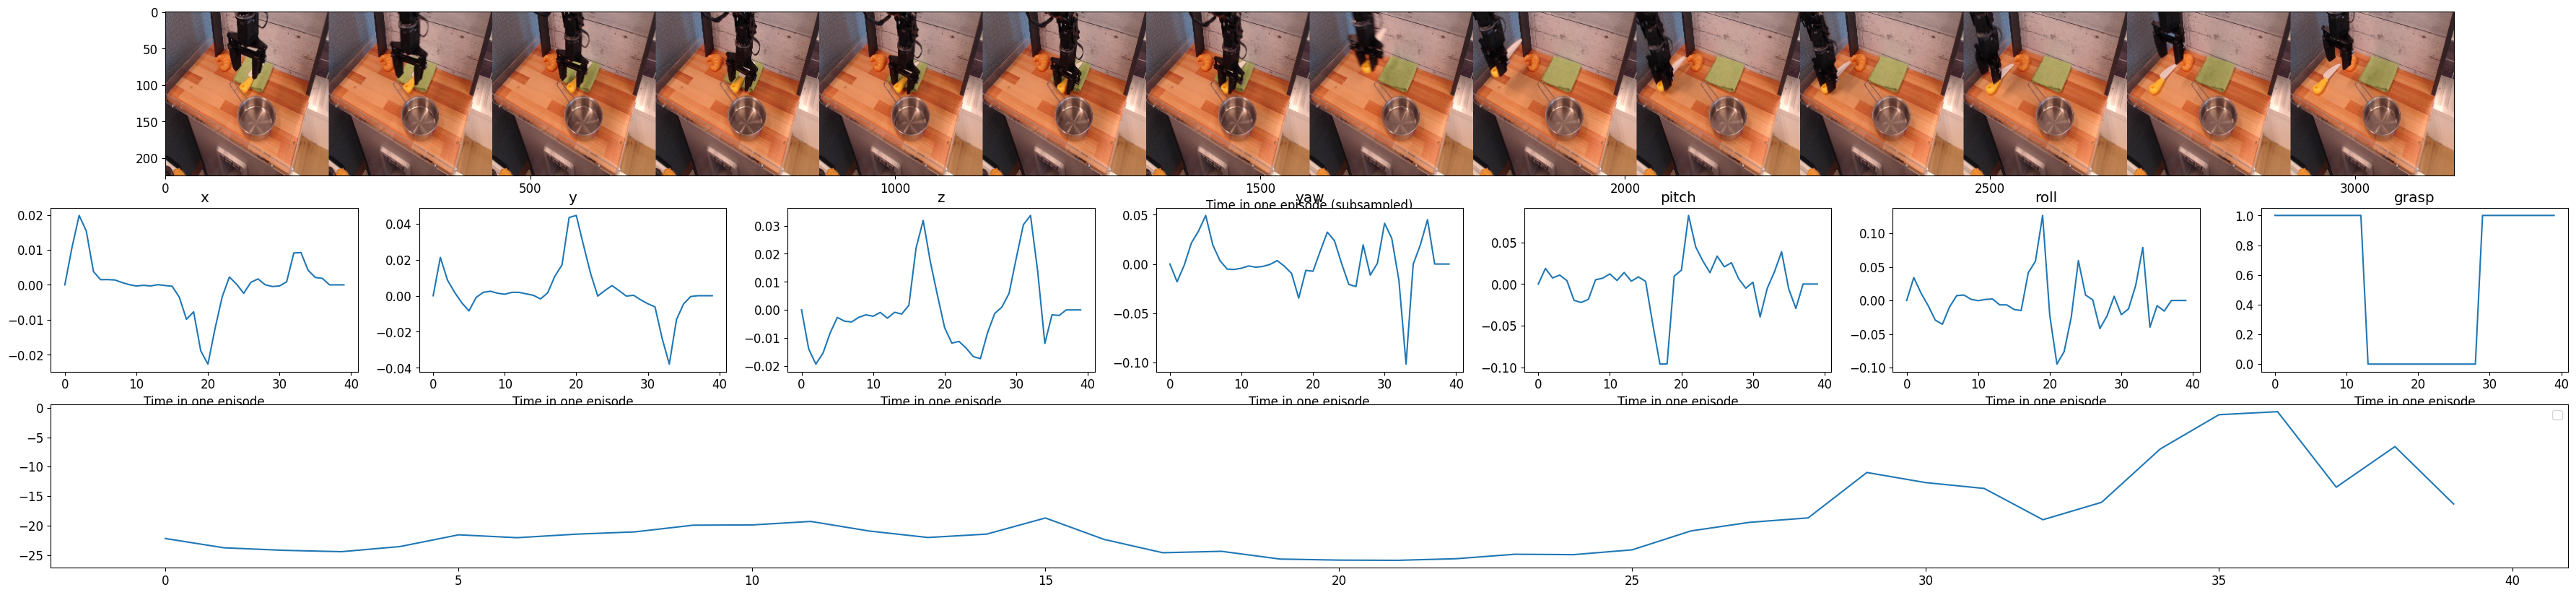

In [8]:
import matplotlib.pyplot as plt

ACTION_DIM_LABELS = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp']

# build image strip to show above actions
img_strip = np.concatenate(np.array(images[::3]), axis=1)

# set up plt figure
figure_layout = [
    ['image'] * len(ACTION_DIM_LABELS),
    ACTION_DIM_LABELS,
    ["value"] * len(ACTION_DIM_LABELS),
]
plt.rcParams.update({'font.size': 12})
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

# plot actions
# pred_actions = np.array(pred_actions).squeeze()
true_actions = np.array(true_actions).squeeze()
for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
  # actions have batch, horizon, dim, in this example we just take the first action for simplicity
  # axs[action_label].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_label].plot(true_actions[:, action_dim], label='ground truth')
  axs[action_label].set_title(action_label)
  axs[action_label].set_xlabel('Time in one episode')

# plot value
axs['value'].plot(pred_values)

axs['image'].imshow(img_strip)
axs['image'].set_xlabel('Time in one episode (subsampled)')
plt.legend()